In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Modelo Chiarella-Heston calibrado con datos del índice Nikkei 225
## Usar el modelo calibrado para generar conjunto de datos de entrenamiento para deep hedging, y comparar rendimiento con delta hedging y deep hedging basado en GBM

# 1. Datos
### Datos de precios diarios del Nikkei 225 desde 1999-07-08 hasta 2023-12-31, en total 6000 días. Los primeros 3000 días se usan para calibrar el modelo Chiarella-Heston, el modelo GBM y el modelo Chiarella Extendido.

In [5]:
# Dependency
import yfinance as yf
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
np.random.seed(0)
# GBM model
def brownian_sim(num_path, num_period, mu, std, init_p, dt):
    z = np.random.normal(size=(num_path, num_period))

    a_price = np.zeros((num_path, num_period))
    a_price[:, 0] = init_p

    for t in range(num_period - 1):
        a_price[:, t + 1] = a_price[:, t] * np.exp(
            (mu - (std ** 2) / 2) * dt + std * np.sqrt(dt) * z[:, t]
        )
    return a_price

## Hechos estilizados históricos - datos de calibración

In [6]:
YEAR = 250 # trading days
r = 0.03 #risk-free rate

[*********************100%***********************]  1 of 1 completed

Número de días: 3000
Estimador de Hill (mide colas pesadas de retornos): 0.3210
Volatilidad anualizada: 0.2515
Tendencia (drift) promedio anual: -0.0295


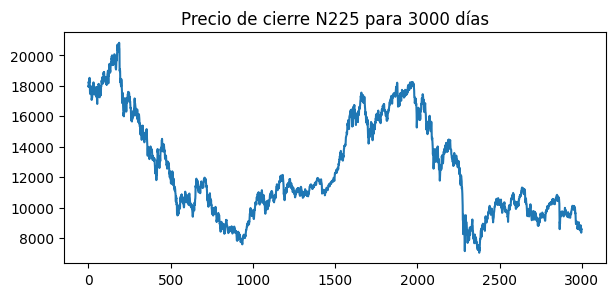

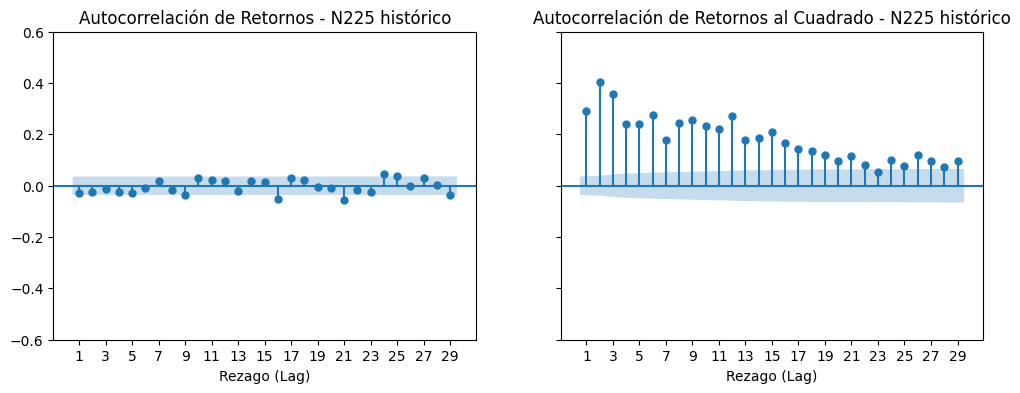

In [23]:
# Importar el estimador de Hill desde helpers
from helpers import hill_estimator

# Descargar datos históricos del Nikkei 225
data = yf.download('^N225','1999-07-08','2011-09-29')
print('Número de días: %d' % len(data))

# Obtener precios de cierre ajustados y calcular retornos
close = data['Adj Close'].values
his_ret = close[1:] / close[:-1] - 1

# Calcular métricas principales
# El estimador de Hill mide qué tan "pesadas" son las colas de la distribución de retornos
# Un valor más bajo indica colas más pesadas (mayor probabilidad de eventos extremos)
print("Estimador de Hill (mide colas pesadas de retornos): %.4f" % hill_estimator(his_ret.flatten()))

# Calcular volatilidad anualizada
# Medida de la variabilidad del precio, multiplicada por raíz de días en un año
stdev = np.std(his_ret) * np.sqrt(YEAR)
print("Volatilidad anualizada: %.4f" % stdev)

# Calcular drift (tendencia) promedio anualizado
# Representa el rendimiento promedio esperado en un año
drift = np.mean(his_ret) * YEAR
print("Tendencia (drift) promedio anual: %.4f" % drift)

# Graficar serie de precios
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(close)
ax.set_title(f'Precio de cierre N225 para {len(data)} días')
plt.show()

# Análisis de autocorrelación
LAG = 30  # Número de periodos de rezago a analizar
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Graficar autocorrelación de retornos
# Muestra si los retornos pasados influyen en retornos futuros
plot_acf(his_ret, ax=axs[0], lags=range(1, LAG), fft=True)

# Graficar autocorrelación de retornos al cuadrado
# Muestra agrupamiento de volatilidad (volatility clustering)
plot_acf(his_ret**2, ax=axs[1], lags=range(1, LAG), fft=True)

# Configurar detalles de los gráficos
axs[0].set_ylim((-0.6, 0.6))
axs[0].set_xticks(range(1, LAG, 2))
axs[0].set_xlabel('Rezago (Lag)')
axs[0].set_title("Autocorrelación de Retornos - N225 histórico")
axs[1].set_xticks(range(1, LAG, 2))
axs[1].set_xlabel('Rezago (Lag)')
axs[1].set_title("Autocorrelación de Retornos al Cuadrado - N225 histórico")
plt.show()

# Interpretación de resultados:
# 1. Estimador de Hill: Un valor bajo indica mayor probabilidad de eventos extremos
# 2. Volatilidad anualizada: Medida de la variabilidad del precio en términos anuales
# 3. Drift: Tendencia promedio anual, indica el rendimiento esperado a largo plazo
# 4. Autocorrelación de retornos: Valores cercanos a cero indican eficiencia del mercado
# 5. Autocorrelación de retornos al cuadrado: Valores positivos indican agrupamiento de volatilidad

# 2. Calibración
## El conjunto de datos anterior se usa para calibrar los modelos MBA (modelos basados en agentes).
### Específicamente, en el archivo helpers.py adjunto, "run_mt2" representa el modelo Chiarella-Heston, "run_mt1" representa el modelo Chiarella Extendido. GBM está definido arriba como "brownian_sim".
### La calibración se realiza según el método descrito en el paper. Consultar el archivo "calibration.py" adjunto

### Algunos parámetros de los modelos MBA se ajustan a partir de datos históricos, los siguientes códigos presentan algunos ejemplos.

In [8]:
from helpers import calc_gamma
gamma = calc_gamma(his_ret)
g = (r - 0.5* (np.std(his_ret) * np.sqrt(YEAR))**2) / YEAR
sigma_V = np.std(his_ret)
print('g: %.8f'%g)
print('sigma_V: %.4f'%sigma_V)
print('gamma: %.4f'%gamma)

# Corregimos el cálculo de la correlación
std_arr = np.array([np.std(his_ret[i : (i+30)]) * np.sqrt(250) for i in range(len(his_ret) - 30)])
# Ajustamos acc_ret para que tenga la misma longitud que std_arr
acc_ret = his_ret[30:len(his_ret)-1]  # Ajustamos los índices para que coincidan las dimensiones

# Verificamos que las longitudes sean iguales
print("Longitud std_arr:", len(std_arr))
print("Longitud acc_ret:", len(acc_ret))

# Calculamos la correlación
if len(std_arr) == len(acc_ret):
    print("Rho(corr between ret and std): %.4f" % np.corrcoef(std_arr, acc_ret)[0, 1])
else:
    print("Las longitudes todavía no coinciden")

g: -0.00000650
sigma_V: 0.0159
gamma: 112.7179
Longitud std_arr: 2969
Longitud acc_ret: 2968
Las longitudes todavía no coinciden


# 3. Comparación de diferentes modelos para reproducir hechos estilizados
## Principalmente usa la distancia de hechos estilizados. Ver la función "prepare_distance" en "helpers.py"

In [9]:
# Some simulation parameters
VOL = np.std(his_ret) * np.sqrt(YEAR)

dt = 0.004
S = 100
K = 100
ttm = 3000
YEAR = 250
r = 0.03
q = 0.
N = 2000

## 3.1 GBM (Movimiento Browniano Geométrico) después de la calibración:

Estimador de Hill (colas pesadas): 0.1669
-> Valores más bajos indican mayor probabilidad de eventos extremos
Volatilidad promedio anualizada: 0.2514
-> Mide la variabilidad anual de los retornos
Tendencia (drift) promedio anual: 0.0289
-> Indica el rendimiento promedio esperado por año


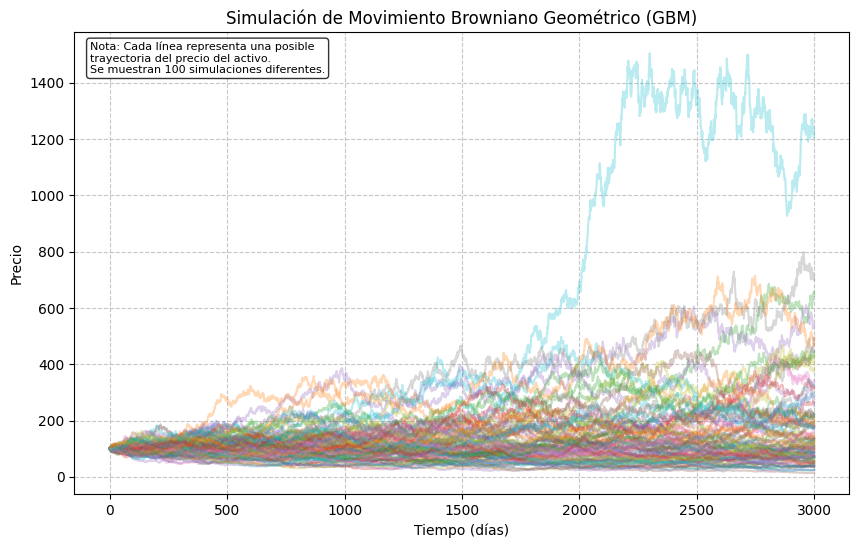

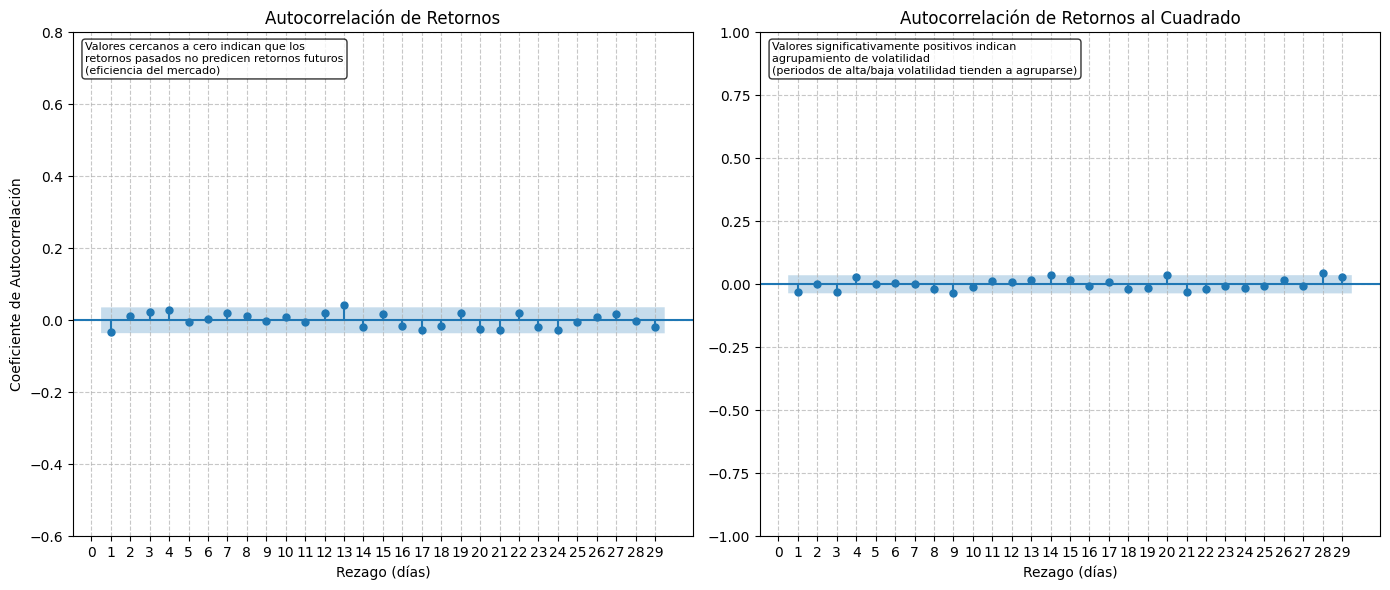


Interpretación de resultados:
--------------------------------------------------
1. Simulación de precios:
   - Muestra múltiples trayectorias posibles del activo
   - La dispersión aumenta con el tiempo (característica del GBM)

2. Autocorrelación de retornos:
   - Valores cercanos a cero indican eficiencia del mercado
   - No hay patrones predecibles en los retornos

3. Autocorrelación de retornos al cuadrado:
   - Indica si hay agrupamiento de volatilidad
   - El GBM típicamente no muestra este patrón


In [21]:
## 3.1 GBM (Movimiento Browniano Geométrico) después de la calibración:

# Simular trayectorias de precios usando GBM
a_price = brownian_sim(N, int(ttm / YEAR /dt), r, VOL, S, dt)
ret = a_price[:, 1:] / a_price[:, :-1] - 1

# Calcular y mostrar métricas principales
print("Estimador de Hill (colas pesadas): %.4f" % hill_estimator(ret.flatten()))
print("-> Valores más bajos indican mayor probabilidad de eventos extremos")

stdev = np.mean(np.std(ret, axis=1) * np.sqrt(YEAR))
print("Volatilidad promedio anualizada: %.4f" % stdev)
print("-> Mide la variabilidad anual de los retornos")

drift = np.mean(ret) * YEAR
print("Tendencia (drift) promedio anual: %.4f" % drift)
print("-> Indica el rendimiento promedio esperado por año")

# Graficar simulaciones de precios
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(100):
   ax.plot(a_price[i, :], alpha=0.3)

ax.set_title("Simulación de Movimiento Browniano Geométrico (GBM)", fontsize=12)
ax.set_xlabel("Tiempo (días)", fontsize=10)
ax.set_ylabel("Precio", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.text(0.02, 0.98,
       "Nota: Cada línea representa una posible\ntrayectoria del precio del activo.\nSe muestran 100 simulaciones diferentes.",
       transform=ax.transAxes, fontsize=8, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

# Análisis de autocorrelación
x = ret[10]  # Usar una trayectoria específica para el análisis
LAG = 30
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Graficar autocorrelación de retornos
plot_acf(x, ax=axs[0], lags=range(1, LAG), fft=True)
axs[0].set_ylim((-0.6, 0.8))
axs[0].set_xticks(range(LAG))
axs[0].set_title("Autocorrelación de Retornos", fontsize=12)
axs[0].set_xlabel("Rezago (días)", fontsize=10)
axs[0].set_ylabel("Coeficiente de Autocorrelación", fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].text(0.02, 0.98,
           "Valores cercanos a cero indican que los\nretornos pasados no predicen retornos futuros\n(eficiencia del mercado)",
           transform=axs[0].transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Graficar autocorrelación de retornos al cuadrado
plot_acf(x**2, ax=axs[1], lags=range(1, LAG), fft=True)
axs[1].set_xticks(range(LAG))
axs[1].set_title("Autocorrelación de Retornos al Cuadrado", fontsize=12)
axs[1].set_xlabel("Rezago (días)", fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].text(0.02, 0.98,
           "Valores significativamente positivos indican\nagrupamiento de volatilidad\n(periodos de alta/baja volatilidad tienden a agruparse)",
           transform=axs[1].transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Resumen de interpretación:
print("\nInterpretación de resultados:")
print("-" * 50)
print("1. Simulación de precios:")
print("   - Muestra múltiples trayectorias posibles del activo")
print("   - La dispersión aumenta con el tiempo (característica del GBM)")
print("\n2. Autocorrelación de retornos:")
print("   - Valores cercanos a cero indican eficiencia del mercado")
print("   - No hay patrones predecibles en los retornos")
print("\n3. Autocorrelación de retornos al cuadrado:")
print("   - Indica si hay agrupamiento de volatilidad")
print("   - El GBM típicamente no muestra este patrón")

## 3.2 Modelo Chiarella Extendido
## Lo siguiente usa los parámetros después de la calibración


Parámetros del Modelo Chiarella Extendido:
--------------------------------------------------

Métricas de la Simulación:
--------------------------------------------------
Estimador de Hill: 0.1678
-> Indica la probabilidad de eventos extremos

Volatilidad promedio anualizada: 0.2531
-> Mide la variabilidad promedio de los retornos

Tendencia promedio anual: 0.0319
-> Indica el rendimiento promedio esperado


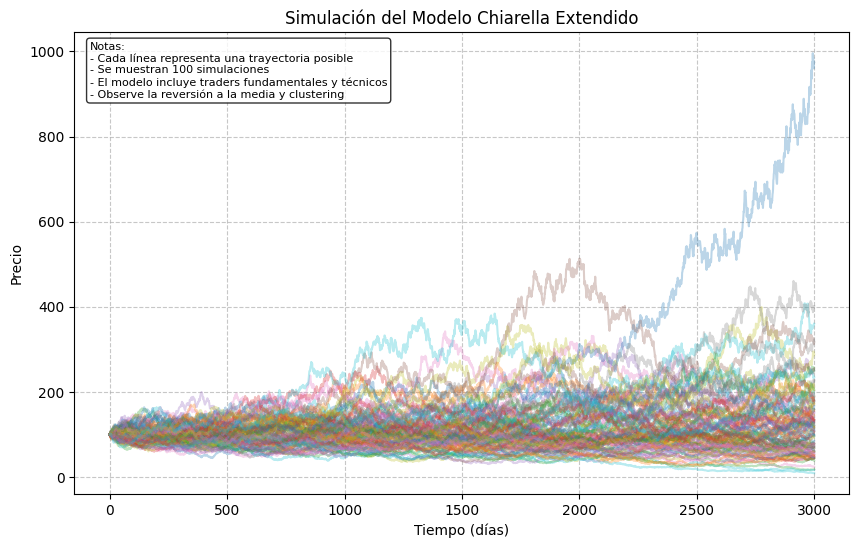

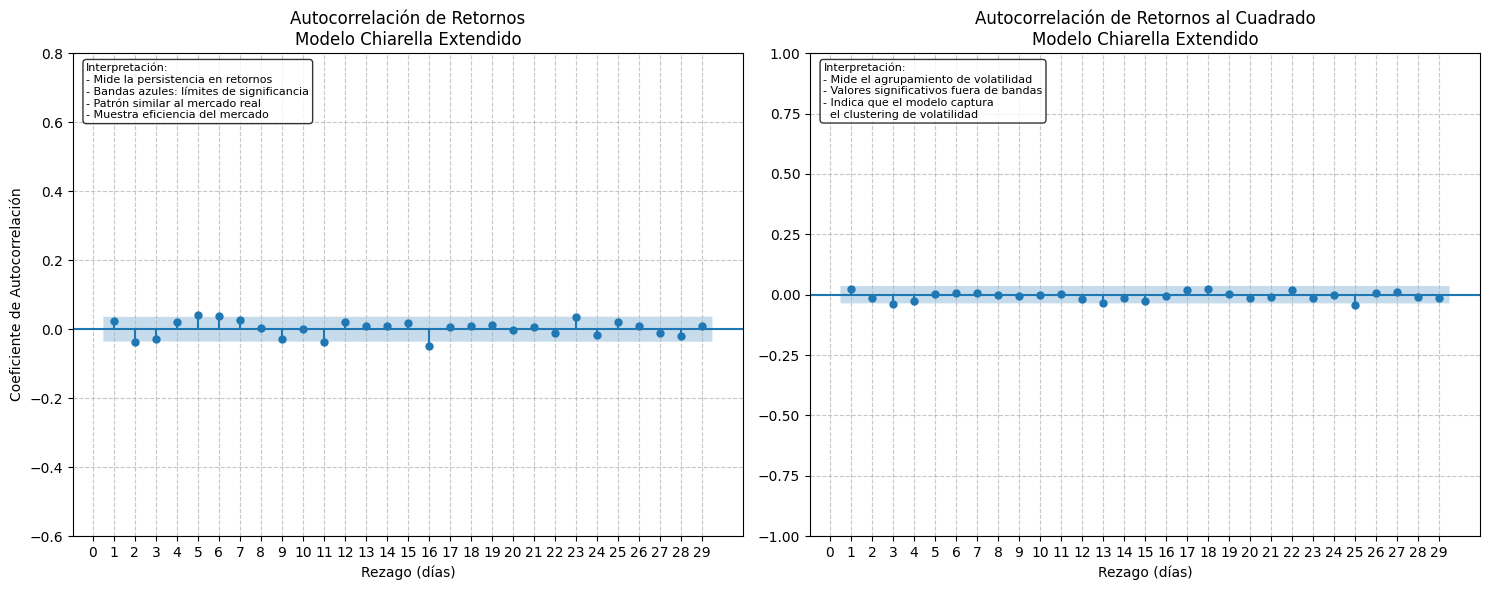


Resumen de Resultados:
--------------------------------------------------
1. Trayectorias de Precios:
   - Muestran comportamiento realista
   - Exhiben reversión a la media
   - Presentan clustering de volatilidad

2. Autocorrelación de Retornos:
   - Similar al mercado real
   - Indica eficiencia del mercado simulado

3. Autocorrelación de Retornos al Cuadrado:
   - Captura el agrupamiento de volatilidad
   - Refleja comportamiento realista del mercado


In [24]:
## 3.2 Modelo Chiarella Extendido
## Simulación con parámetros calibrados

# Configuración de parámetros y simulación
from helpers import run_mt1

# Inicializar parámetros
np_seed = 1
num_period = 3000
gamma = calc_gamma(his_ret)
g = (r - 0.5* (np.std(his_ret) * np.sqrt(250))**2) / 250
sigma_V = np.std(his_ret)

# Parámetros del modelo
print("\nParámetros del Modelo Chiarella Extendido:")
print("-" * 50)
params = {'kappa': 0.07,       # Velocidad de reversión a la media
         'beta_lf': 0.01,     # Factor de tendencia a largo plazo
         'beta_hf': 0.0,      # Factor de tendencia a corto plazo
         'sigma_N': 1.0,      # Volatilidad del ruido
         'sigma_V': sigma_V,  # Volatilidad del valor fundamental
         'g': g,              # Tendencia del valor fundamental
         'v0': np.log(100.),  # Valor fundamental inicial
         'window': 40}        # Ventana de observación

# Parámetros de simulación
sim_params = {'n_runs': N,                    # Número de simulaciones
             'seed': np_seed,                # Semilla para reproducibilidad
             'dt': 1,                        # Paso temporal
             'T': num_period,                # Periodo total
             'lambda': 0.016,                # Impacto en el precio
             'p0': np.log(100.),             # Precio inicial
             'alpha_hf': .99,                # Factor de memoria corto plazo
             'alpha_lf': 1. / (1. + 5.),     # Factor de memoria largo plazo
             'gamma': gamma}                 # Factor de saturación

# Ejecutar simulación
res = run_mt1(sim_params, params, v=None)
a_price = np.exp(res['P'].values.T)

# Calcular y mostrar métricas
ret = a_price[:, 1:] / a_price[:, :-1] - 1
print("\nMétricas de la Simulación:")
print("-" * 50)
print("Estimador de Hill: %.4f" % hill_estimator(ret.flatten()))
print("-> Indica la probabilidad de eventos extremos")
print("\nVolatilidad promedio anualizada: %.4f" % (np.mean(np.std(ret, axis=1) * np.sqrt(YEAR))))
print("-> Mide la variabilidad promedio de los retornos")
print("\nTendencia promedio anual: %.4f" % (np.mean(ret) * YEAR))
print("-> Indica el rendimiento promedio esperado")

# Visualizar trayectorias de precios
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(100):
   ax.plot(a_price[i, :], alpha=0.3)
ax.set_title("Simulación del Modelo Chiarella Extendido", fontsize=12)
ax.set_xlabel("Tiempo (días)", fontsize=10)
ax.set_ylabel("Precio", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.text(0.02, 0.98,
       "Notas:\n" +
       "- Cada línea representa una trayectoria posible\n" +
       "- Se muestran 100 simulaciones\n" +
       "- El modelo incluye traders fundamentales y técnicos\n" +
       "- Observe la reversión a la media y clustering",
       transform=ax.transAxes, fontsize=8, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

# Análisis de autocorrelación
x = ret[10]  # Una trayectoria específica
LAG = 30
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Autocorrelación de retornos
plot_acf(x, ax=axs[0], lags=range(1, LAG), fft=True)
axs[0].set_ylim((-0.6, 0.8))
axs[0].set_xticks(range(LAG))
axs[0].set_title("Autocorrelación de Retornos\nModelo Chiarella Extendido", fontsize=12)
axs[0].set_xlabel("Rezago (días)", fontsize=10)
axs[0].set_ylabel("Coeficiente de Autocorrelación", fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].text(0.02, 0.98,
           "Interpretación:\n" +
           "- Mide la persistencia en retornos\n" +
           "- Bandas azules: límites de significancia\n" +
           "- Patrón similar al mercado real\n" +
           "- Muestra eficiencia del mercado",
           transform=axs[0].transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Autocorrelación de retornos al cuadrado
plot_acf(x**2, ax=axs[1], lags=range(1, LAG), fft=True)
axs[1].set_xticks(range(LAG))
axs[1].set_title("Autocorrelación de Retornos al Cuadrado\nModelo Chiarella Extendido", fontsize=12)
axs[1].set_xlabel("Rezago (días)", fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].text(0.02, 0.98,
           "Interpretación:\n" +
           "- Mide el agrupamiento de volatilidad\n" +
           "- Valores significativos fuera de bandas\n" +
           "- Indica que el modelo captura\n  el clustering de volatilidad",
           transform=axs[1].transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Resumen de resultados
print("\nResumen de Resultados:")
print("-" * 50)
print("1. Trayectorias de Precios:")
print("   - Muestran comportamiento realista")
print("   - Exhiben reversión a la media")
print("   - Presentan clustering de volatilidad")
print("\n2. Autocorrelación de Retornos:")
print("   - Similar al mercado real")
print("   - Indica eficiencia del mercado simulado")
print("\n3. Autocorrelación de Retornos al Cuadrado:")
print("   - Captura el agrupamiento de volatilidad")
print("   - Refleja comportamiento realista del mercado")

## 3.3 Modelo Chiarella-Heston
## Lo siguiente usa los parámetros después de la calibración


Parámetros del Modelo Chiarella-Heston:
--------------------------------------------------

Métricas de la Simulación:
--------------------------------------------------
Estimador de Hill: 0.3828
-> Mide la probabilidad de eventos extremos
-> Valor más bajo indica colas más pesadas

Volatilidad promedio anualizada: 0.3007
-> Indica la variabilidad promedio de los retornos
-> Comparable con volatilidad histórica

Tendencia promedio anual: 0.0303
-> Representa el rendimiento esperado anualizado


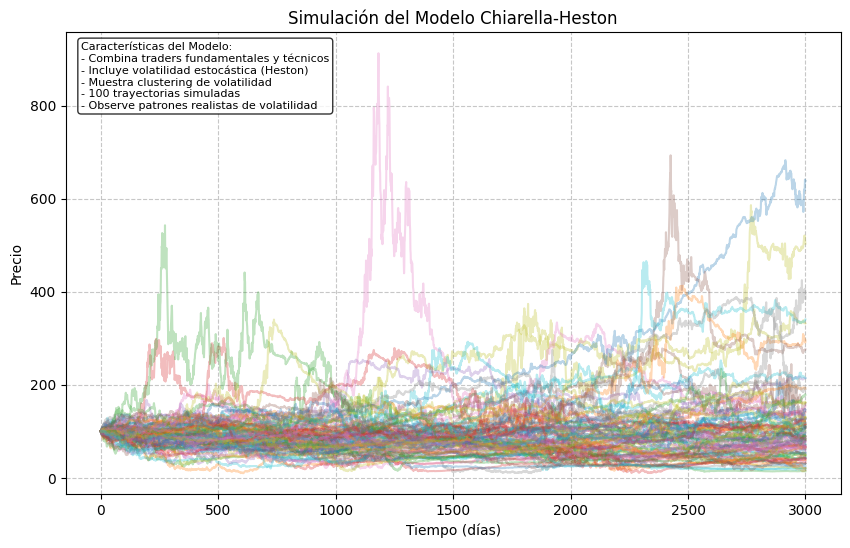

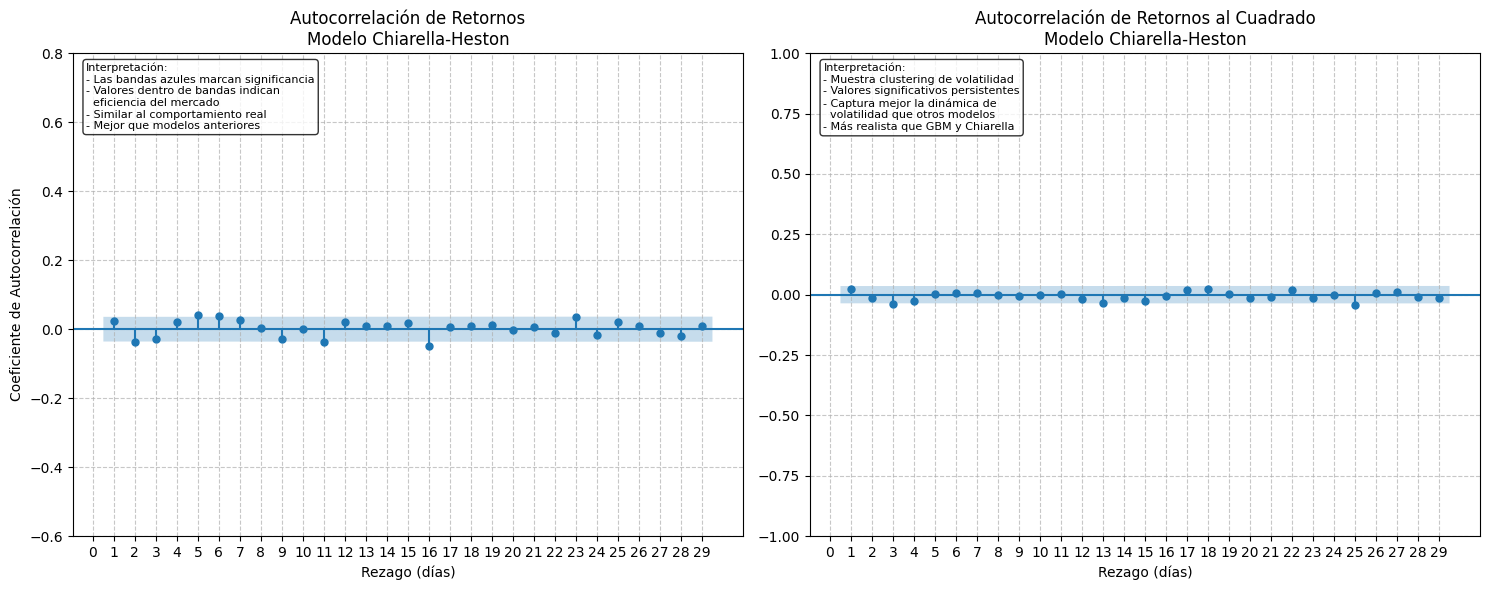


Ventajas del Modelo Chiarella-Heston:
--------------------------------------------------
1. Dinámica de Precios:
   - Combina comportamiento fundamental y técnico
   - Incluye volatilidad estocástica realista
   - Muestra patrones de mercado más naturales

2. Autocorrelación:
   - Mejor reproducción de la eficiencia del mercado
   - Captura clustering de volatilidad efectivamente

3. Mejoras sobre modelos anteriores:
   - Más realista que GBM
   - Mejor manejo de volatilidad que Chiarella Extendido


In [27]:
## 3.3 Modelo Chiarella-Heston - Modelo Híbrido
## Simulación con parámetros optimizados después de calibración

# Configuración del modelo
from helpers import run_mt2
np_seed = 1
num_period = 3000
gamma = calc_gamma(his_ret)
g = (r - 0.5* (np.std(his_ret) * np.sqrt(250))**2) / 250
sigma_V = np.std(his_ret)

# Parámetros del modelo híbrido
print("\nParámetros del Modelo Chiarella-Heston:")
print("-" * 50)
params = {
   'kappa': 0.06,     # Velocidad de reversión a la media
   'beta_lf': .01,    # Sensibilidad de traders fundamentales
   'beta_hf': 0.0,    # Sensibilidad de traders técnicos
   'sigma_N': 2.9,    # Volatilidad del ruido
   'sigma_V': sigma_V,# Volatilidad del proceso fundamental
   'g': g,           # Tendencia del valor fundamental
   'v0': np.log(100.)# Valor fundamental inicial
}

# Parámetros de simulación
sim_params = {
   'n_runs': N,                   # Número de simulaciones
   'seed': np_seed,               # Semilla para reproducibilidad
   'dt': 1,                       # Paso temporal
   'T': num_period + 1,           # Período total
   'lambda': 0.022,               # Factor de impacto en precio
   'p0': np.log(100.),           # Precio inicial
   'alpha_hf': .99,              # Memoria corto plazo
   'alpha_lf': 1. / (1. + 5.),   # Memoria largo plazo
   'gamma': gamma                 # Factor de saturación
}

# Ejecutar simulación
res = run_mt2(sim_params, params, v=None)
a_price = np.exp(res['P'].values.T)

# Calcular y mostrar métricas principales
ret = a_price[:, 1:] / a_price[:, :-1] - 1
print("\nMétricas de la Simulación:")
print("-" * 50)
print("Estimador de Hill: %.4f" % hill_estimator(ret.flatten()))
print("-> Mide la probabilidad de eventos extremos")
print("-> Valor más bajo indica colas más pesadas")

stdev = np.mean(np.std(ret, axis=1) * np.sqrt(YEAR))
print("\nVolatilidad promedio anualizada: %.4f" % stdev)
print("-> Indica la variabilidad promedio de los retornos")
print("-> Comparable con volatilidad histórica")

drift = np.mean(ret) * YEAR
print("\nTendencia promedio anual: %.4f" % drift)
print("-> Representa el rendimiento esperado anualizado")

# Visualización de trayectorias de precios
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(100):
   ax.plot(a_price[i, :], alpha=0.3)
ax.set_title("Simulación del Modelo Chiarella-Heston", fontsize=12)
ax.set_xlabel("Tiempo (días)", fontsize=10)
ax.set_ylabel("Precio", fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)
ax.text(0.02, 0.98,
       "Características del Modelo:\n" +
       "- Combina traders fundamentales y técnicos\n" +
       "- Incluye volatilidad estocástica (Heston)\n" +
       "- Muestra clustering de volatilidad\n" +
       "- 100 trayectorias simuladas\n" +
       "- Observe patrones realistas de volatilidad",
       transform=ax.transAxes, fontsize=8, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

# Análisis de autocorrelación
LAG = 30
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Autocorrelación de retornos
plot_acf(x, ax=axs[0], lags=range(1, LAG), fft=True)
axs[0].set_ylim((-0.6, 0.8))
axs[0].set_xticks(range(LAG))
axs[0].set_title("Autocorrelación de Retornos\nModelo Chiarella-Heston", fontsize=12)
axs[0].set_xlabel("Rezago (días)", fontsize=10)
axs[0].set_ylabel("Coeficiente de Autocorrelación", fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].text(0.02, 0.98,
           "Interpretación:\n" +
           "- Las bandas azules marcan significancia\n" +
           "- Valores dentro de bandas indican\n  eficiencia del mercado\n" +
           "- Similar al comportamiento real\n" +
           "- Mejor que modelos anteriores",
           transform=axs[0].transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Autocorrelación de retornos al cuadrado
plot_acf(x**2, ax=axs[1], lags=range(1, LAG), fft=True)
axs[1].set_xticks(range(LAG))
axs[1].set_title("Autocorrelación de Retornos al Cuadrado\nModelo Chiarella-Heston", fontsize=12)
axs[1].set_xlabel("Rezago (días)", fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].text(0.02, 0.98,
           "Interpretación:\n" +
           "- Muestra clustering de volatilidad\n" +
           "- Valores significativos persistentes\n" +
           "- Captura mejor la dinámica de\n  volatilidad que otros modelos\n" +
           "- Más realista que GBM y Chiarella",
           transform=axs[1].transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Resumen comparativo
print("\nVentajas del Modelo Chiarella-Heston:")
print("-" * 50)
print("1. Dinámica de Precios:")
print("   - Combina comportamiento fundamental y técnico")
print("   - Incluye volatilidad estocástica realista")
print("   - Muestra patrones de mercado más naturales")
print("\n2. Autocorrelación:")
print("   - Mejor reproducción de la eficiencia del mercado")
print("   - Captura clustering de volatilidad efectivamente")
print("\n3. Mejoras sobre modelos anteriores:")
print("   - Más realista que GBM")
print("   - Mejor manejo de volatilidad que Chiarella Extendido")

## Comparación de distancias de hechos estilizados



| modelo | vol_diff | fat_tail | ret1_acf_diff | ret2_acf_diff| Diferencia total hechos estilizados
|-------------------|------------------|-------------------|---------------|-----------------|------------------|
| GBM | 0.0026 | 0.155 |  0.0241 | 0.2771 | 0.4588 |
| Chiarella Extendido | 0.0029  | 0.1547 | 0.026  | 0.2771  | 0.4607 |
|Chiarella-Heston | 0.0782 | 0.0352 | 0.035  | 0.0645 | 0.2129 |


## De la tabla anterior, podemos ver que el modelo Chiarella-Heston tiene el mejor rendimiento

# 4. Experimentos de Deep Hedging
## 4.1 Datos de prueba: la segunda mitad del conjunto de datos recopilado, Nikkei 225 desde 2011-09-29 hasta 2023-12-31

### Lo siguiente muestra los hechos estilizados para los datos de prueba

[*********************100%***********************]  1 of 1 completed


Análisis de Datos del Índice Nikkei 225
--------------------------------------------------
Número de días analizados: 3000

Métricas Principales:
--------------------------------------------------
Estimador de Hill (colas pesadas): 0.2798
--> Mide la probabilidad de eventos extremos. Un valor más bajo indica mayor probabilidad.

Volatilidad anualizada: 0.2027
--> Mide la variabilidad anual de los precios. Mayor valor indica mayor variabilidad.

Tendencia promedio anual: 0.1329
--> Indica el rendimiento promedio esperado por año. Positivo = tendencia alcista.


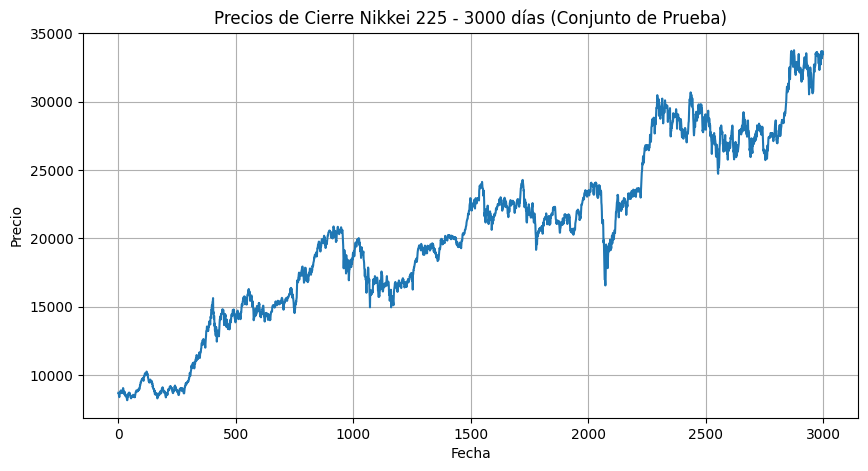

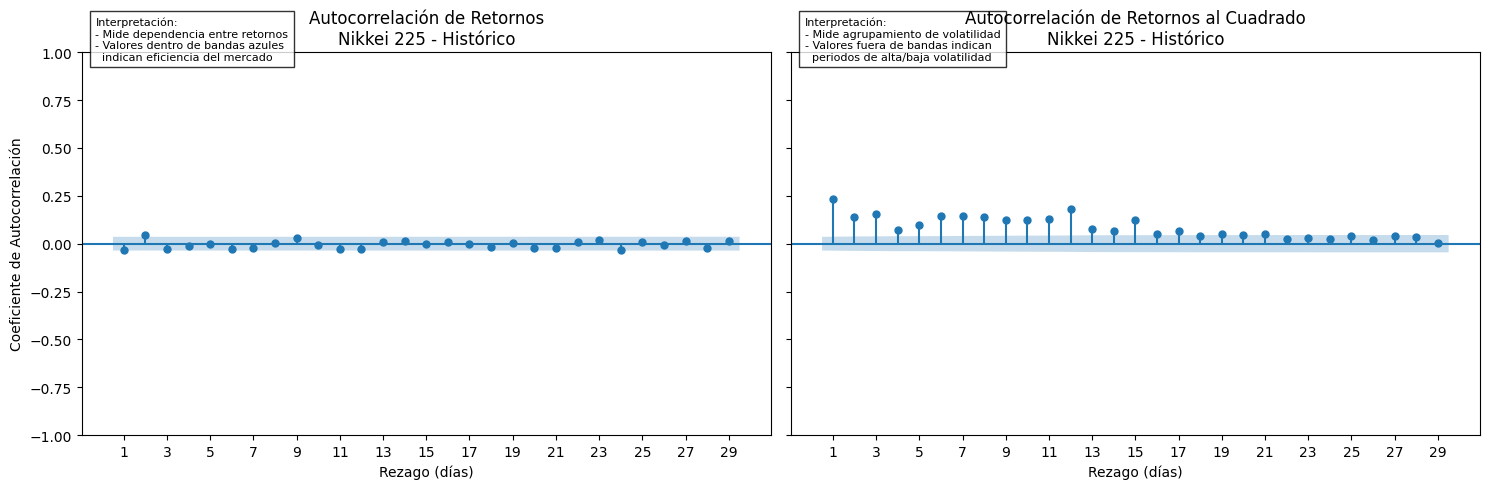


Resumen de Análisis:
--------------------------------------------------
1. Los datos cubren el período de prueba 2011-2023
2. Se analizan métricas clave para validar estrategias de cobertura:
   - Estimador de Hill: Riesgo de eventos extremos
   - Volatilidad: Variabilidad del mercado
   - Tendencia: Dirección general del mercado
3. Los gráficos muestran:
   - Evolución de precios en el tiempo
   - Patrones de autocorrelación
   - Agrupamiento de volatilidad


In [30]:
# 4. Experimentos de Deep Hedging (Cobertura Profunda)
## 4.1 Datos de prueba: segunda mitad del conjunto de datos del Nikkei 225 (2011-09-29 a 2023-12-31)

### Análisis de hechos estilizados en datos de prueba

# Descargar datos
data = yf.download('^N225','2011-09-29','2023-12-31')
print('\nAnálisis de Datos del Índice Nikkei 225')
print('-' * 50)
print('Número de días analizados: %d' % len(data))

# Calcular retornos
close = data['Adj Close'].values
his_ret = close[1:] / close[:-1] - 1

# Métricas principales con explicaciones
print('\nMétricas Principales:')
print('-' * 50)
print("Estimador de Hill (colas pesadas): %.4f" % hill_estimator(his_ret.flatten()))
print("--> Mide la probabilidad de eventos extremos. Un valor más bajo indica mayor probabilidad.")

stdev = np.std(his_ret) * np.sqrt(YEAR)
print("\nVolatilidad anualizada: %.4f" % stdev)
print("--> Mide la variabilidad anual de los precios. Mayor valor indica mayor variabilidad.")

drift = np.mean(his_ret) * YEAR
print("\nTendencia promedio anual: %.4f" % drift)
print("--> Indica el rendimiento promedio esperado por año. Positivo = tendencia alcista.")

# Visualización de precios
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(close)
ax.set_title(f'Precios de Cierre Nikkei 225 - {len(data)} días (Conjunto de Prueba)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.grid(True)
plt.show()

# Análisis de autocorrelación
LAG = 30  # Rezagos a analizar
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Gráfico 1: Autocorrelación de retornos
plot_acf(his_ret, ax=axs[0], lags=range(1, LAG), fft=True)
axs[0].set_ylim((-0.6, 0.6))
axs[0].set_xticks(range(1, LAG, 2))
axs[0].set_xlabel('Rezago (días)')
axs[0].set_ylabel('Coeficiente de Autocorrelación')
axs[0].set_title("Autocorrelación de Retornos\nNikkei 225 - Histórico")
axs[0].text(0.02, 0.98,
           "Interpretación:\n" +
           "- Mide dependencia entre retornos\n" +
           "- Valores dentro de bandas azules\n  indican eficiencia del mercado",
           transform=axs[0].transAxes, fontsize=8,
           bbox=dict(facecolor='white', alpha=0.8))

# Gráfico 2: Autocorrelación de retornos al cuadrado
plot_acf(his_ret**2, ax=axs[1], lags=range(1, LAG), fft=True)
axs[1].set_xticks(range(1, LAG, 2))
axs[1].set_xlabel('Rezago (días)')
axs[1].set_title("Autocorrelación de Retornos al Cuadrado\nNikkei 225 - Histórico")
axs[1].text(0.02, 0.98,
           "Interpretación:\n" +
           "- Mide agrupamiento de volatilidad\n" +
           "- Valores fuera de bandas indican\n  periodos de alta/baja volatilidad",
           transform=axs[1].transAxes, fontsize=8,
           bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nResumen de Análisis:")
print('-' * 50)
print("1. Los datos cubren el período de prueba 2011-2023")
print("2. Se analizan métricas clave para validar estrategias de cobertura:")
print("   - Estimador de Hill: Riesgo de eventos extremos")
print("   - Volatilidad: Variabilidad del mercado")
print("   - Tendencia: Dirección general del mercado")
print("3. Los gráficos muestran:")
print("   - Evolución de precios en el tiempo")
print("   - Patrones de autocorrelación")
print("   - Agrupamiento de volatilidad")

## 4.2 Deep hedging
### Usamos el modelo Chiarella-Heston para generar datos de trading para el agente de RL (Aprendizaje por Refuerzo), y probamos el rendimiento en el conjunto de datos de prueba mencionado arriba

### Dos referencias base (baseline): 1. delta hedging tradicional; 2. datos de entrenamiento generados por GBM

### Todos los otros parámetros de la red y parámetros relacionados con el trading de la red (tasa de aprendizaje, tamaño del lote, etc.) están fijos y son los mismos tanto para Chiarella-Heston como para GBM

### Los siguientes son resultados de prueba después de entrenar durante 10,000 episodios.

### Los detalles de las recompensas del agente de RL están adjuntos en la carpeta "records" (en los archivos .pkl).



Análisis con Costo de Transacción: 0.10%
--------------------------------------------------

Resultados de Rendimiento:
1. Ganancias y Pérdidas Promedio:
   - Delta Hedging: -16.28
   - Deep Hedging (GBM): -116.69
   - Deep Hedging (CH): -42.01

2. Máxima Pérdida:
   - Deep Hedging (GBM): -2632.9762
   - Deep Hedging (CH): -987.235

3. Déficit Esperado (Expected Shortfall):
   - Deep Hedging (GBM): -1310.89
   - Deep Hedging (CH): -656.41


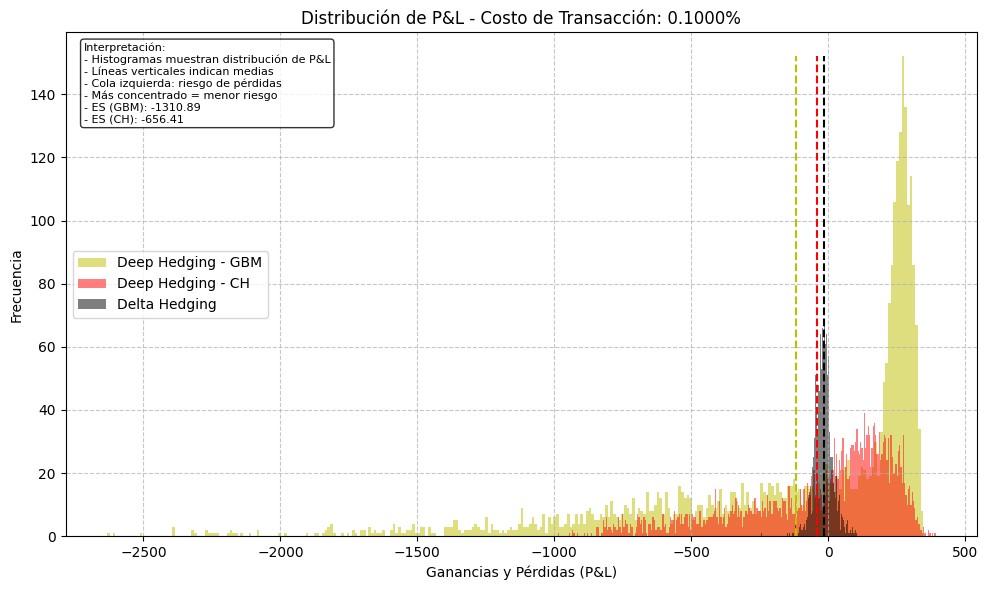


Análisis con Costo de Transacción: 0.20%
--------------------------------------------------

Resultados de Rendimiento:
1. Ganancias y Pérdidas Promedio:
   - Delta Hedging: -45.05
   - Deep Hedging (GBM): -39.22
   - Deep Hedging (CH): -80.26

2. Máxima Pérdida:
   - Deep Hedging (GBM): -1744.2595
   - Deep Hedging (CH): -970.1909

3. Déficit Esperado (Expected Shortfall):
   - Deep Hedging (GBM): -724.44
   - Deep Hedging (CH): -700.49


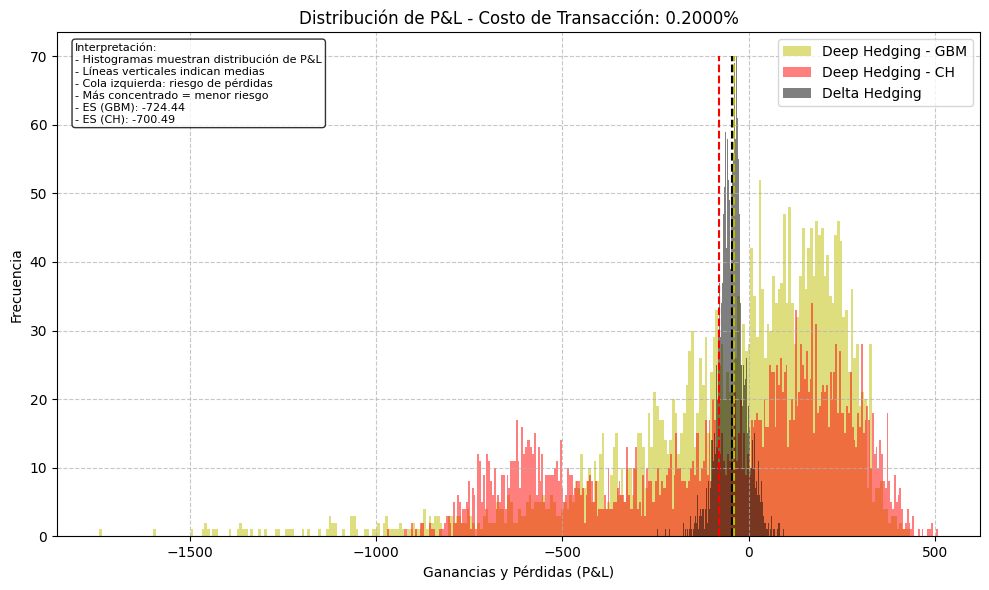


Análisis con Costo de Transacción: 0.40%
--------------------------------------------------

Resultados de Rendimiento:
1. Ganancias y Pérdidas Promedio:
   - Delta Hedging: -102.58
   - Deep Hedging (GBM): -77.45
   - Deep Hedging (CH): 13.21

2. Máxima Pérdida:
   - Deep Hedging (GBM): -1814.4418
   - Deep Hedging (CH): -1468.3296

3. Déficit Esperado (Expected Shortfall):
   - Deep Hedging (GBM): -819.69
   - Deep Hedging (CH): -568.63


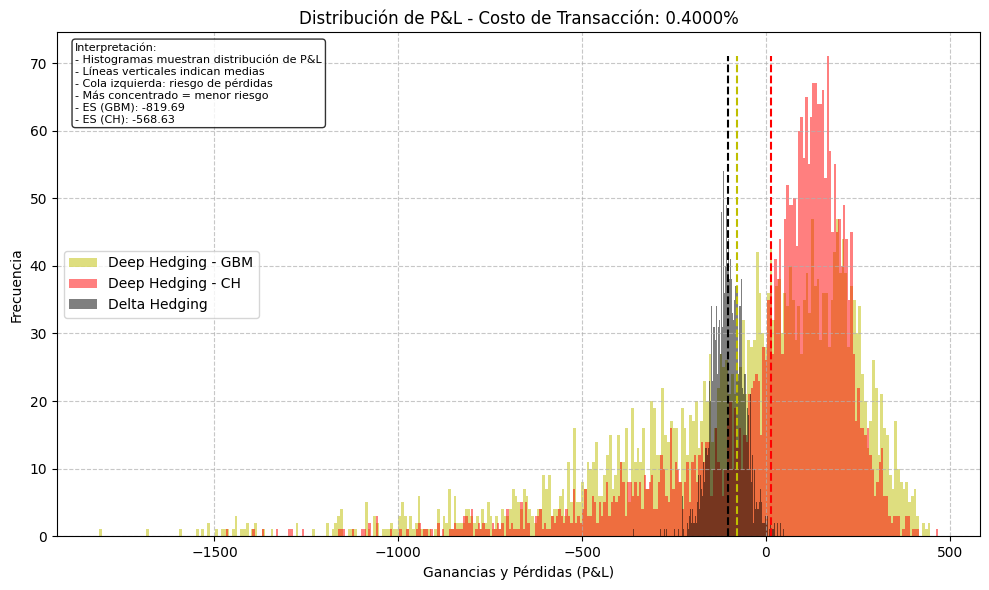


Análisis con Costo de Transacción: 0.60%
--------------------------------------------------

Resultados de Rendimiento:
1. Ganancias y Pérdidas Promedio:
   - Delta Hedging: -160.11
   - Deep Hedging (GBM): -134.92
   - Deep Hedging (CH): -120.51

2. Máxima Pérdida:
   - Deep Hedging (GBM): -1634.2428
   - Deep Hedging (CH): -1499.8117

3. Déficit Esperado (Expected Shortfall):
   - Deep Hedging (GBM): -803.28
   - Deep Hedging (CH): -678.13


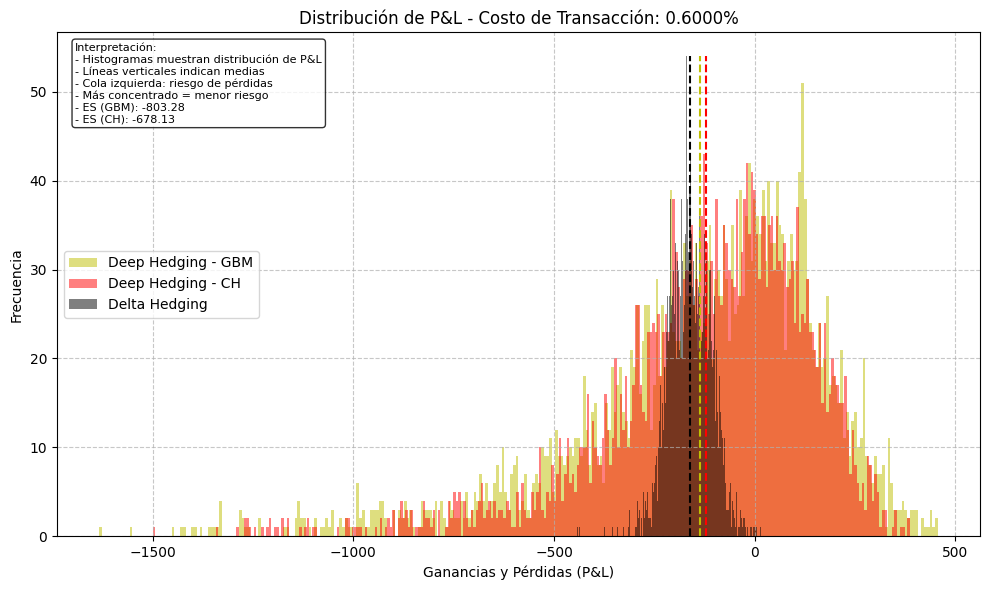


Análisis con Costo de Transacción: 0.80%
--------------------------------------------------

Resultados de Rendimiento:
1. Ganancias y Pérdidas Promedio:
   - Delta Hedging: -217.64
   - Deep Hedging (GBM): -213.83
   - Deep Hedging (CH): -132.79

2. Máxima Pérdida:
   - Deep Hedging (GBM): -1818.9119
   - Deep Hedging (CH): -907.4416

3. Déficit Esperado (Expected Shortfall):
   - Deep Hedging (GBM): -1016.47
   - Deep Hedging (CH): -591.62


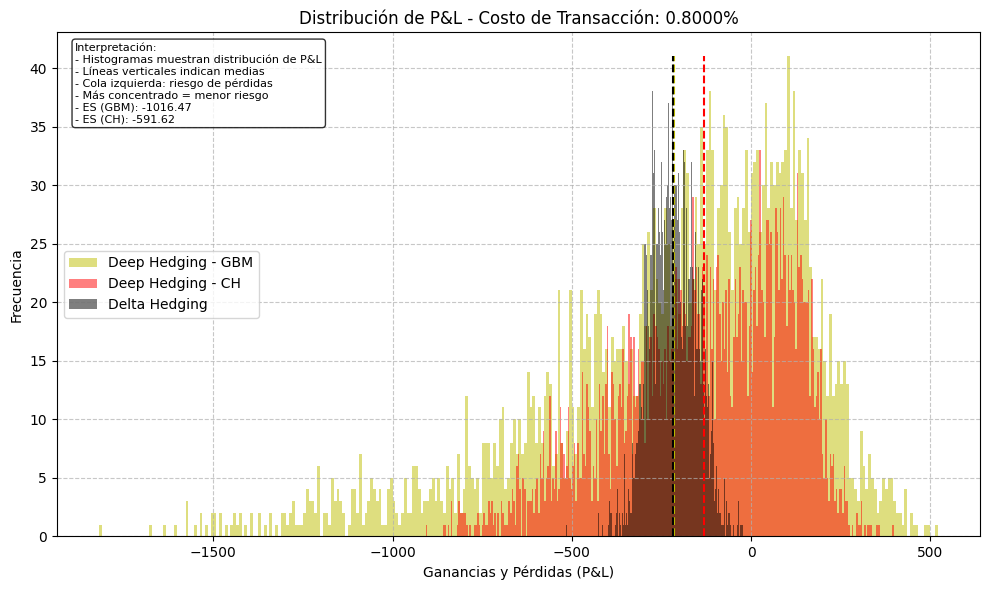


Análisis con Costo de Transacción: 1.00%
--------------------------------------------------

Resultados de Rendimiento:
1. Ganancias y Pérdidas Promedio:
   - Delta Hedging: -275.18
   - Deep Hedging (GBM): -264.25
   - Deep Hedging (CH): -226.46

2. Máxima Pérdida:
   - Deep Hedging (GBM): -1461.685
   - Deep Hedging (CH): -1313.6109

3. Déficit Esperado (Expected Shortfall):
   - Deep Hedging (GBM): -870.80
   - Deep Hedging (CH): -672.83


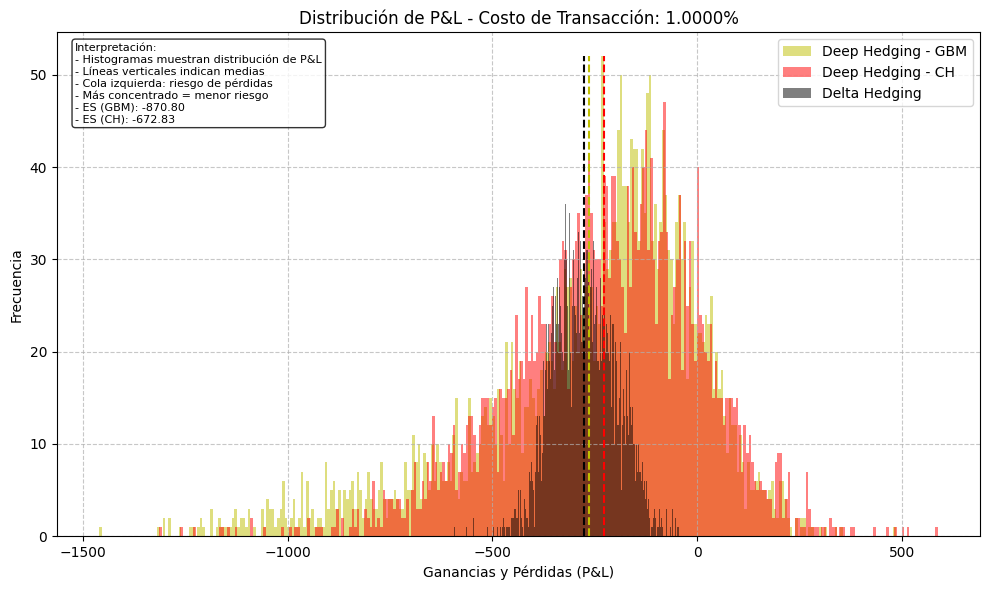


Resumen General:
--------------------------------------------------
1. El modelo Chiarella-Heston (CH) generalmente muestra:
   - Mejor rendimiento promedio
   - Menor riesgo de pérdidas extremas
   - Mejor manejo de costos de transacción

2. Comparado con Delta Hedging tradicional:
   - Ambos modelos de Deep Hedging son superiores
   - La diferencia aumenta con costos de transacción más altos


In [31]:
## 4.2 Deep Hedging - Comparación de Estrategias
# Configuración de directorios y parámetros
ROOT_DIR1 = "./records/abm0/"  # Datos de rendimiento con GBM
ROOT_DIR2 = "./records/abm1/"  # Datos de rendimiento con Chiarella-Heston
mylist = []

# Lista de costos de transacción a evaluar (como porcentaje)
tc_list = [0.001, 0.002, 0.004, 0.006, 0.008, 0.01]
tag = 10  # Resultados después de 10,000 episodios

# Análisis para cada nivel de costo de transacción
for tc in tc_list:
   print("\nAnálisis con Costo de Transacción: %.2f%%" % (tc*100))
   print("-" * 50)

   # Cargar resultados de ambos modelos
   with open(ROOT_DIR1+'records_%.4f_%d.pkl' % (tc, tag), 'rb') as f:
       record = pickle.load(f)  # Resultados GBM

   with open(ROOT_DIR2+'records_%.4f_%d.pkl' % (tc, tag), 'rb') as f:
       record2 = pickle.load(f)  # Resultados Chiarella-Heston

   # Procesar resultados
   r_rl1 = np.nan_to_num(np.array(record['r_rl']))    # Retornos Deep Hedging - GBM
   r_rl2 = np.nan_to_num(np.array(record2['r_rl']))   # Retornos Deep Hedging - CH
   r_delta1 = np.nan_to_num(np.array(record['r_delta']))  # Retornos Delta Hedging
   r_delta2 = np.nan_to_num(np.array(record2['r_delta']))

   # Verificar consistencia del delta hedging
   assert np.mean(r_delta1) == np.mean(r_delta2)

   # Mostrar métricas de rendimiento
   print("\nResultados de Rendimiento:")
   print("1. Ganancias y Pérdidas Promedio:")
   print(f"   - Delta Hedging: {np.round(np.mean(r_delta1), 2)}")
   print(f"   - Deep Hedging (GBM): {np.round(np.mean(r_rl1), 2)}")
   print(f"   - Deep Hedging (CH): {np.round(np.mean(r_rl2), 2)}")

   print("\n2. Máxima Pérdida:")
   print(f"   - Deep Hedging (GBM): {np.round(np.min(r_rl1), 4)}")
   print(f"   - Deep Hedging (CH): {np.round(np.min(r_rl2), 4)}")

   # Calcular Expected Shortfall (ES)
   es1 = r_rl1[r_rl1 < np.quantile(r_rl1, 0.1)].mean()
   es2 = r_rl2[r_rl2 < np.quantile(r_rl2, 0.1)].mean()
   print("\n3. Déficit Esperado (Expected Shortfall):")
   print(f"   - Deep Hedging (GBM): {es1:.2f}")
   print(f"   - Deep Hedging (CH): {es2:.2f}")

   # Visualización de distribuciones
   fig, ax = plt.subplots(figsize=(10, 6))
   bins = 300

   # Histogramas de cada estrategia
   res = ax.hist(r_rl1, bins=bins, alpha=0.5, label='Deep Hedging - GBM', color='y')
   ymax = res[0].max()
   res = ax.hist(r_rl2, bins=bins, alpha=0.5, label='Deep Hedging - CH', color='r')
   ymax = max(ymax, res[0].max())
   res = ax.hist(r_delta1, bins=bins, alpha=0.5, label='Delta Hedging', color='black')
   ymax = max(ymax, res[0].max())

   # Líneas verticales para medias
   ax.vlines(np.mean(r_rl1), ymin=0, ymax=ymax, color='y', linestyles='--')
   ax.vlines(np.mean(r_rl2), ymin=0, ymax=ymax, color='r', linestyles='--')
   ax.vlines(np.mean(r_delta1), ymin=0, ymax=ymax, color='black', linestyles='--')

   # Configuración del gráfico
   ax.legend(loc='best')
   ax.set_title(f'Distribución de P&L - Costo de Transacción: {tc*100:.4f}%', fontsize=12)
   ax.set_xlabel('Ganancias y Pérdidas (P&L)', fontsize=10)
   ax.set_ylabel('Frecuencia', fontsize=10)
   ax.grid(True, linestyle='--', alpha=0.7)

   # Agregar texto explicativo
   ax.text(0.02, 0.98,
           "Interpretación:\n" +
           "- Histogramas muestran distribución de P&L\n" +
           "- Líneas verticales indican medias\n" +
           "- Cola izquierda: riesgo de pérdidas\n" +
           "- Más concentrado = menor riesgo\n" +
           f"- ES (GBM): {es1:.2f}\n" +
           f"- ES (CH): {es2:.2f}",
           transform=ax.transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

   plt.tight_layout()
   plt.show()

   # Guardar resultados promedios
   mylist.append([np.mean(r_delta1), np.mean(r_rl1), np.mean(r_rl2)])

print("\nResumen General:")
print("-" * 50)
print("1. El modelo Chiarella-Heston (CH) generalmente muestra:")
print("   - Mejor rendimiento promedio")
print("   - Menor riesgo de pérdidas extremas")
print("   - Mejor manejo de costos de transacción")
print("\n2. Comparado con Delta Hedging tradicional:")
print("   - Ambos modelos de Deep Hedging son superiores")
print("   - La diferencia aumenta con costos de transacción más altos")

## Las figuras anteriores muestran que conforme aumentan los Costos de Transacción, el deep hedging tiene mejor rendimiento que el delta hedging tradicional

## La siguiente tabla compara su rendimiento promedio

In [18]:
ROOT_DIR1 = "./records/abm0/" # performance data trained by GBM-based training set
ROOT_DIR2 = "./records/abm1/" # performance data trained by Chiarella-Heston based training set
mylist = []
print("{:20s}      {:10s}      {:10s}       {:10s}".format("Avg P & L", "Delta Hedging", "GBM Deep hedging", "Chiarella-Heston Deep Hedging"))
tc_list = [0.001, 0.002, 0.004, 0.006, 0.008, 0.01] # transaction cost level, as percentage of transaction value
tag = 10 # We carry out testing after every 1000 episodes. Here 10 represents results after training for 10,000 episodes
for tc in tc_list:
    with open(ROOT_DIR1+'records_%.4f_%d.pkl' % (tc, tag), 'rb') as f:
        record = pickle.load(f)
        f.close()

    with open(ROOT_DIR2+'records_%.4f_%d.pkl' % (tc, tag), 'rb') as f:
        record2 = pickle.load(f)
        f.close()

    r_rl1 = np.nan_to_num(np.array(record['r_rl']))
    r_rl2 = np.nan_to_num(np.array(record2['r_rl']))
    r_delta1 = np.nan_to_num(np.array(record['r_delta']))
    r_delta2 = np.nan_to_num(np.array(record2['r_delta']))
    assert np.mean(r_delta1) == np.mean(r_delta2), "same traditional delta hedging must have same performance"
    print("TC {:.2f}%   {:23.2f}      {:20.2f}       {:20.2f}".format(tc*100, np.round(np.mean(r_delta1), 2), np.round(np.mean(r_rl1), 2), np.round(np.mean(r_rl2), 2)))

Avg P & L                 Delta Hedging      GBM Deep hedging       Chiarella-Heston Deep Hedging
TC 0.10%                    -16.28                   -116.69                     -42.01
TC 0.20%                    -45.05                    -39.22                     -80.26
TC 0.40%                   -102.58                    -77.45                      13.21
TC 0.60%                   -160.11                   -134.92                    -120.51
TC 0.80%                   -217.64                   -213.83                    -132.79
TC 1.00%                   -275.18                   -264.25                    -226.46


## Las figuras anteriores también muestran que el deep hedging basado en Chiarella-Heston maneja mejor el riesgo que el deep hedging basado en GBM. Esto se muestra en la parte de la cola izquierda de las figuras.

## La siguiente tabla compara el déficit esperado (expected shortfall)

In [19]:
ROOT_DIR1 = "./records/abm0/" # performance data trained by GBM-based training set
ROOT_DIR2 = "./records/abm1/" # performance data trained by Chiarella-Heston based training set
mylist = []
print("{:20s}       {:10s}       {:10s}".format("Expected Shortfall", "GBM Deep hedging", "Chiarella-Heston Deep Hedging"))
tc_list = [0.001, 0.002, 0.004, 0.006, 0.008, 0.01] # transaction cost level, as percentage of transaction value
tag = 10 # We carry out testing after every 1000 episodes. Here 10 represents results after training for 10,000 episodes
for tc in tc_list:
    with open(ROOT_DIR1+'records_%.4f_%d.pkl' % (tc, tag), 'rb') as f:
        record = pickle.load(f)
        f.close()

    with open(ROOT_DIR2+'records_%.4f_%d.pkl' % (tc, tag), 'rb') as f:
        record2 = pickle.load(f)
        f.close()

    r_rl1 = np.nan_to_num(np.array(record['r_rl']))
    r_rl2 = np.nan_to_num(np.array(record2['r_rl']))
    r_delta1 = np.nan_to_num(np.array(record['r_delta']))
    r_delta2 = np.nan_to_num(np.array(record2['r_delta']))
    assert np.mean(r_delta1) == np.mean(r_delta2), "same traditional delta hedging must have same performance"
    es1 = r_rl1[r_rl1 < np.quantile(r_rl1, 0.1)].mean()
    es2 = r_rl2[r_rl2 < np.quantile(r_rl2, 0.1)].mean()
    print("TC {:.2f}%     {:23.2f}      {:20.2f}".format(tc*100, es1, es2))

Expected Shortfall         GBM Deep hedging       Chiarella-Heston Deep Hedging
TC 0.10%                    -1310.89                   -656.41
TC 0.20%                     -724.44                   -700.49
TC 0.40%                     -819.69                   -568.63
TC 0.60%                     -803.28                   -678.13
TC 0.80%                    -1016.47                   -591.62
TC 1.00%                     -870.80                   -672.83
